## Uso de Decision Trees para mostrar explicação de decisões via regras derivadas dos ramos da DT.

Number of rows:  30240
      Language         Program  PowerLimit  Size  Cost   Package      Core   
0           C      BubbleSort            5  1000  1016  0.030090  0.016174  \
2           C      BubbleSort            5  1000  1016  0.034790  0.016541   
3           C      BubbleSort            5  1000  1016  0.039490  0.020203   
4           C      BubbleSort            5  1000  1016  0.031921  0.015259   
5           C      BubbleSort            5  1000  1016  0.038147  0.017029   
...        ...             ...         ...   ...   ...       ...       ...   
31345    Rust   SelectionSort         1000  5000   444  0.167053  0.149353   
31346    Rust   SelectionSort         1000  5000   444  0.172302  0.151428   
31347    Rust   SelectionSort         1000  5000   444  0.111938  0.062805   
31348    Rust   SelectionSort         1000  5000   444  0.180603  0.163147   
31349    Rust   SelectionSort         1000  5000   444  0.117249  0.059753   

            GPU  DRAM  Time  Temperature

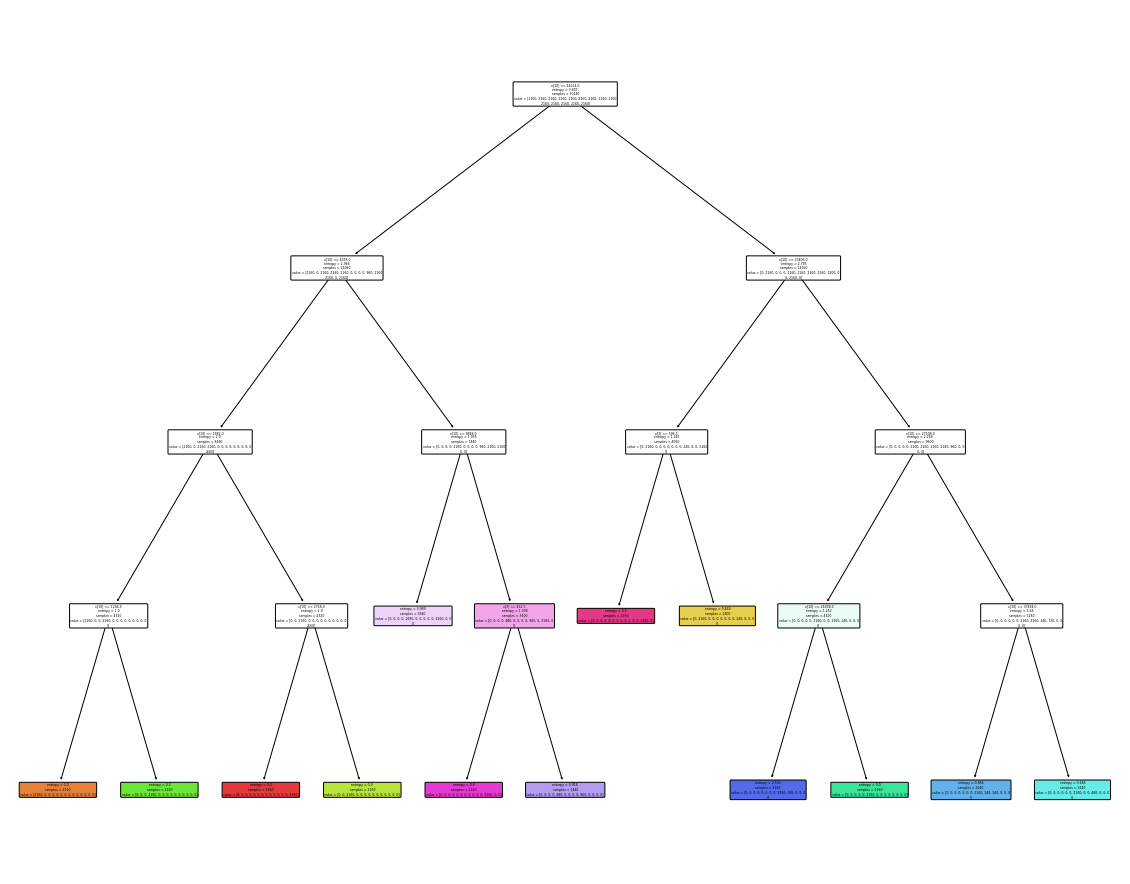

In [32]:
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt

file_name = '../measurements.csv'
df = pd.read_csv(file_name, header=0, delimiter=",", decimal=".")

#Outliers treatment
#NOTE: This will remove 14*3*5*3*2 entries (14 languages, 3 sorting algorithms, 5 PowerLimit, 3 Sizes and 2 cases - best and worst executions)

# Agrupar o DataFrame por colunas "Language" e "Program"
grouped = df.groupby(['Language', 'Program', 'PowerLimit', 'Size'])

# Inicializar um DataFrame vazio para armazenar o resultado
df_removed_entries = pd.DataFrame()

# Iterar sobre cada grupo
for group_name, group_df in grouped:
    
    # Identificar o índice da melhor (menor tempo) e pior (maior tempo) entrada no grupo
    best_entry_index = group_df['Time'].idxmin()
    worst_entry_index = group_df['Time'].idxmax()
    if(best_entry_index==worst_entry_index):
        worst_entry_index+=1
    # Remover as linhas com base nos índices encontrados e adicionar ao DataFrame resultante 
    group_df = group_df.drop([best_entry_index, worst_entry_index])
    
    # Concatenar o DataFrame do grupo com o DataFrame resultante
    df_removed_entries = pd.concat([df_removed_entries, group_df])

df = df_removed_entries.copy()
# Imprimir o DataFrame resultante
print("Number of rows: ", len(df.index))
print(df)

replace_map = {
    'Program': {
        'BubbleSort ': 0,
        'QuickSort ': 1,
        'SelectionSort ': 2
    }
}

replace_map2 = {'Language': {
                    'C ':0 ,
                    'Python Interpreted ': 1, 
                    'Python Compilled ': 2,
                    'Haskell ':3,
                    'Java ':4,
                    'C++ ':5,
                    'Prolog ':6,
                    'Ruby ':7,
                    'PHP ':8,
                    'Kotlin ':9,
                    'JavaScript ':10,
                    'C# ':11,
                    'Rust ':12,
                    'Go ':13
                    }}

y = df["Language"]
x = df.drop(columns=['Language'])
x.replace(replace_map, inplace=True)


clf = tree.DecisionTreeClassifier(random_state=2023, criterion='entropy', ccp_alpha=0.1)

plt.figure(figsize=(20, 16))
clf = clf.fit(x, y)
tree.plot_tree(clf, filled=True, rounded=True)
plt.show()


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [34]:
x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=2023)

In [35]:
clf = DecisionTreeClassifier(random_state=2023)
clf = clf.fit(x_train,y_train)

In [36]:
predictions_train = clf.predict(x_train)
predictions_test = clf.predict(x_test)

In [37]:
print("Classification report for training data")
print(classification_report(y_train, predictions_train))
print("\nClassification report for test data")
print(classification_report(y_test, predictions_test))

Classification report for training data
                     precision    recall  f1-score   support

                 C        1.00      1.00      1.00      1623
                C#        1.00      1.00      1.00      1595
               C++        1.00      1.00      1.00      1629
                Go        1.00      1.00      1.00      1634
           Haskell        1.00      1.00      1.00      1618
              Java        1.00      1.00      1.00      1589
        JavaScript        1.00      1.00      1.00      1618
            Kotlin        1.00      1.00      1.00      1621
               PHP        1.00      1.00      1.00      1628
            Prolog        1.00      1.00      1.00      1626
  Python Compilled        1.00      1.00      1.00      1650
Python Interpreted        1.00      1.00      1.00      1615
              Ruby        1.00      1.00      1.00      1596
              Rust        1.00      1.00      1.00      1638

           accuracy                        

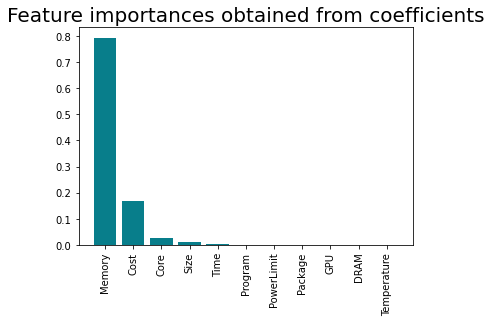

In [38]:
# Feature importance
clf.fit(x_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': clf.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [39]:
y = df["Language"]
x = df.drop(columns=['Language', 'Temperature', 'DRAM', 'GPU', 'Package', 'PowerLimit'])
x.replace(replace_map, inplace=True)

x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=2023)

x_test

,Program,Size,Cost,Core,Time,Memory
967,1,1000,632,0.197815,57,13752
13865,1,2500,968,0.239990,78,26420
30633,0,5000,703,6.013367,394,24532
18401,2,2500,727,0.585205,46,45592
26688,2,5000,538,0.912231,83,28124
...,...,...,...,...,...,...
7879,1,1000,727,0.295349,76,46256
21672,1,5000,919,0.298401,117,27192
13164,2,2500,374,0.272339,75,8212
27943,0,5000,632,0.683655,65,27088


### Tuning

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
              'min_samples_leaf': [0.05, 0.1, 0.2]}

grid_search = GridSearchCV(clf, param_grid, cv=10)

grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

predictions_train = grid_search.predict(x_train)
predictions_test = grid_search.predict(x_test)

print("Classification report for training data")
print(classification_report(y_train, predictions_train, zero_division=1))
print("\nClassification report for test data")
print(classification_report(y_test, predictions_test, zero_division=1))

Best parameters: {'max_depth': 8, 'min_samples_leaf': 0.05}
Best score: 0.9330246913580247
Classification report for training data
                     precision    recall  f1-score   support

                 C        1.00      1.00      1.00      1623
                C#        1.00      1.00      1.00      1595
               C++        1.00      1.00      1.00      1629
                Go        1.00      1.00      1.00      1634
           Haskell        0.94      0.66      0.77      1618
              Java        1.00      1.00      1.00      1589
        JavaScript        0.82      1.00      0.90      1618
            Kotlin        0.82      1.00      0.90      1621
               PHP        0.89      0.89      0.89      1628
            Prolog        0.70      0.52      0.59      1626
  Python Compilled        0.90      1.00      0.95      1650
Python Interpreted        1.00      1.00      1.00      1615
              Ruby        1.00      1.00      1.00      1596
              

### Previsão da linguagem dados alguns valores com o modelo treinado

In [48]:
# Assuming you have already defined the variables:
Program = "QuickSort "
Size = 2500
Cost = 800
Memory = 2000
Core = 0.02
Time = 50

# Create a dictionary with the input data
input_data = {
    'Program': [replace_map['Program'][Program]],
    'Memory': [Memory],
    'Cost': [Cost],
    'Core': [Core],
    'Size': [Size],
    'Time': [Time]
}

# Create a DataFrame from the input data
input_df = pd.DataFrame(input_data)

# Extract the feature columns (x) from the input DataFrame
x = input_df[["Program", "Size", "Cost", "Core", "Time", "Memory"]]

# Make predictions for the input data
prediction = grid_search.predict(x)

# Retrieve the inferred value of "Language"
inferred_language = prediction[0]

print("Inferred Language:", inferred_language)


Inferred Language: Rust 
